In [6]:
import wget
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [41]:
data= "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv"
data= wget.download(data)
df= pd.read_csv(data)

100% [..........................................................................] 1423529 / 1423529

In [18]:
df.count()

longitude             20640
latitude              20640
housing_median_age    20640
total_rooms           20640
total_bedrooms        20433
population            20640
households            20640
median_income         20640
median_house_value    20640
ocean_proximity       20640
dtype: int64

In [42]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [43]:
df.dtypes

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object

# Exploratory data analysis (EDA)

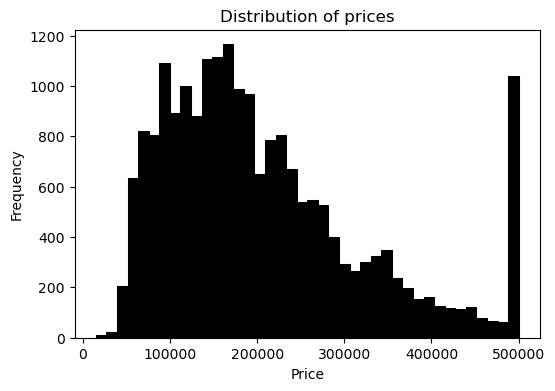

In [17]:
plt.figure(figsize=(6, 4))

sns.histplot(df.median_house_value , bins=40, color='black', alpha=1)
plt.ylabel('Frequency')
plt.xlabel('Price')
plt.title('Distribution of prices')

plt.show()

The distribution has a right tail but it is not long

# Preparing the dataset

In [56]:
df2 = df.copy()
df2 = df2[(df2.ocean_proximity == "INLAND") | (df2.ocean_proximity == "<1H OCEAN")]
df2 = df2[['latitude','longitude','housing_median_age','total_rooms','total_bedrooms','population','households'\
           ,'median_income','median_house_value']]


### Question 1

In [57]:
df2.isnull().sum()

latitude                0
longitude               0
housing_median_age      0
total_rooms             0
total_bedrooms        157
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

### Question 2

In [61]:
df2.population.median()

1195.0

### Question 3

#### Preparation of data

In [103]:
np.random.seed(42)

n = len(df2)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n) # Permits to create array from 0 to n
np.random.shuffle(idx) #Randomly orders idx

df_shuffled = df2.iloc[idx] # creates df shuffled

df_train = df_shuffled.iloc[:n_train].copy()  # We can do it considering .iloc is positional and does not consider index
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

In [104]:
y_train = np.log1p(df_train.median_house_value.values) # aplication of nplog+1. It is onnly applied to regressed variables
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

del df_train['median_house_value'] # Delation of original value
del df_val['median_house_value']
del df_test['median_house_value']

#### missing values dealing and functions preparing

In [88]:
#df_train_zeros=df_train.fillna(0)
#df_train_mean = df_train.copy()
#df_train_mean.total_bedrooms.fillna(value=df_train.total_bedrooms.mean(),inplace=True)

In [95]:
def prepare_X_fill_0(df):
    df_num = df.fillna(0)
    X = df_num.values
    return X

In [96]:
def prepare_X_fill_mean(df):
    df_num = df.copy()
    df_num.total_bedrooms.fillna(value=df_train.total_bedrooms.mean(),inplace=True)
    X = df_num.values
    return X

In [97]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [98]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

#### Linear regresion running

In [119]:
#zeros

x_train_zeros =  prepare_X_fill_0(df_train)
w_0, w = train_linear_regression(x_train_zeros, y_train)


x_val_zeros = prepare_X_fill_0(df_val)

y_pred = w_0 + x_val_zeros.dot(w)

round(rmse(y_val, y_pred),2)

0.34

In [117]:
#mean

x_train_mean =  prepare_X_fill_mean(df_train)
w_0, w = train_linear_regression(x_train_mean, y_train)


x_val_zeros = prepare_X_fill_0(df_val)

y_pred = w_0 + x_val_zeros.dot(w)

round(rmse(y_val, y_pred),2)

0.34

Both are equally good

### Question 4

In [122]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [129]:
for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w_0, w = train_linear_regression_reg(x_train_zeros, y_train, r=r)
    y_pred = w_0 + x_val_zeros.dot(w)
    print('%6s,%.2f' % (r, rmse(y_val, y_pred))) # El menor es 0

     0,0.34
 1e-06,0.34
0.0001,0.34
 0.001,0.34
  0.01,0.34
   0.1,0.34
     1,0.34
     5,0.35
    10,0.35


The best is just 0 meaning, using not regularization

### Question 5

In [133]:
rmse_resultantes = []

In [134]:
for seed in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    np.random.seed(seed)
    idx = np.arange(n)
    np.random.shuffle(idx)
    df_shuffled = df2.iloc[idx]

    df_train = df_shuffled.iloc[:n_train].copy()  
    df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
    df_test = df_shuffled.iloc[n_train+n_val:].copy()
    
    y_train = np.log1p(df_train.median_house_value.values)
    y_val = np.log1p(df_val.median_house_value.values)
    y_test = np.log1p(df_test.median_house_value.values)

    del df_train['median_house_value'] 
    del df_val['median_house_value']
    del df_test['median_house_value']
    
    x_train_zeros =  prepare_X_fill_0(df_train)
    w_0, w = train_linear_regression(x_train_zeros, y_train)
    x_val_zeros = prepare_X_fill_0(df_val)

    y_pred = w_0 + x_val_zeros.dot(w)
    
    rmse_resultantes.append(rmse(y_val, y_pred))
   


In [136]:
round(np.std(np.array(rmse_resultantes)),3)

0.005

### Question 6

In [141]:
np.random.seed(9)
idx = np.arange(n)
np.random.shuffle(idx)
df_shuffled = df2.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()  
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

del df_train['median_house_value'] 
del df_val['median_house_value']
del df_test['median_house_value']

df_big_train = pd.concat([df_train,df_val])
y_big_train = np.concatenate([y_train,y_val])


In [142]:
x_big_train =  prepare_X_fill_0(df_big_train)
w_0, w = train_linear_regression_reg(x_train_zeros, y_train, r=0.001)

x_test = prepare_X_fill_0(df_test)

y_pred = w_0 + x_test.dot(w)

round(rmse(y_test, y_pred),2)

0.33

### Extra: Traing to put together normal distribution and our distribution (did not work)

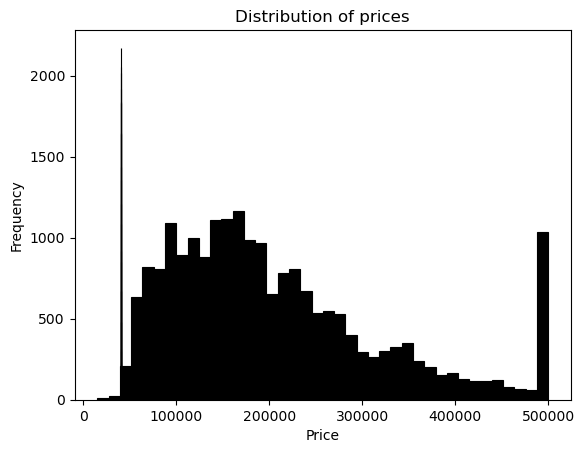

In [34]:
# Create a gaussian distribution-
x = np.random.normal(loc = 40000, scale = 2.0, size = 26000)


# Compare the distributions using 'histplot()' in seaborn with different bin sizes for x & y-
sns.histplot(data = x, bins = 40, label = 'normal dist')
sns.histplot(df.median_house_value , bins=40, color='black', alpha=1,label="median house values")
plt.ylabel('Frequency')
plt.xlabel('Price')
plt.title('Distribution of prices')

plt.show()

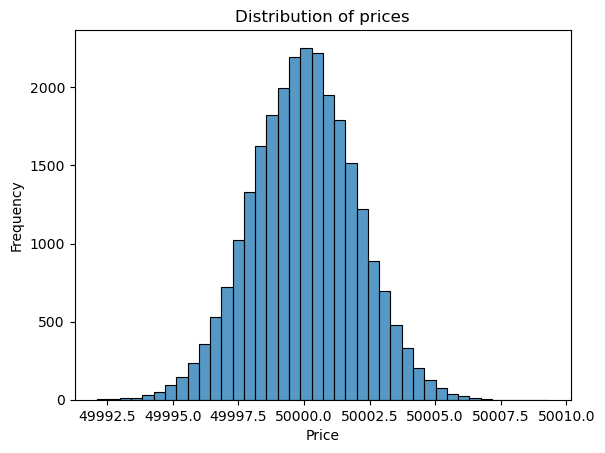

In [33]:
x = np.random.normal(loc = 50000, scale = 2.0, size = 26000)
sns.histplot(data = x, bins = 40, label = 'normal dist')
plt.ylabel('Frequency')
plt.xlabel('Price')
plt.title('Distribution of prices')

plt.show()